In [1]:
# set_determinism : monai에서 제공하는 seed값 고정 util.
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

In [6]:
root_dir = '/data/train/running/l/input_augmented'


train_images = sorted(
    glob.glob(os.path.join(root_dir, "*_T1.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(root_dir, "*_l.nii.gz")))
train_brains = sorted(
    glob.glob(os.path.join(root_dir, "*_b.nii.gz")))
train_masks = sorted(
    glob.glob(os.path.join(root_dir, "*_m.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name, "brain": brain_name, "mask": mask_name}
    for image_name, label_name, brain_name, mask_name in zip(train_images, train_labels, train_brains, train_masks)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [7]:
train_files

[{'image': '/data/train/running/l/input_augmented/s_14040501_00_0_T1.nii.gz',
  'label': '/data/train/running/l/input_augmented/s_14040501_00_0_l.nii.gz',
  'brain': '/data/train/running/l/input_augmented/s_14040501_00_0_b.nii.gz',
  'mask': '/data/train/running/l/input_augmented/s_14040501_00_0_m.nii.gz'},
 {'image': '/data/train/running/l/input_augmented/s_14040501_01_d_T1.nii.gz',
  'label': '/data/train/running/l/input_augmented/s_14040501_01_d_l.nii.gz',
  'brain': '/data/train/running/l/input_augmented/s_14040501_01_d_b.nii.gz',
  'mask': '/data/train/running/l/input_augmented/s_14040501_01_d_m.nii.gz'},
 {'image': '/data/train/running/l/input_augmented/s_14040501_02_d_T1.nii.gz',
  'label': '/data/train/running/l/input_augmented/s_14040501_02_d_l.nii.gz',
  'brain': '/data/train/running/l/input_augmented/s_14040501_02_d_b.nii.gz',
  'mask': '/data/train/running/l/input_augmented/s_14040501_02_d_m.nii.gz'},
 {'image': '/data/train/running/l/input_augmented/s_14040501_03_d_T1.nii.

In [66]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label", "brain", "mask"]),
        EnsureChannelFirstd(keys=["image", "label", "brain", "mask"]),
#         Spacingd(keys=["image", "label"], pixdim=(
#             1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label", "brain", "mask"], axcodes="RAS"),
#         Orientationd(keys=["image"], axcodes="LPS"),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=-57, a_max=164,
#             b_min=0.0, b_max=1.0, clip=True,
#         ),
#         CropForegroundd(keys=["image", "label"], source_key="image"),
#         EnsureTyped(keys=["image", "label"]),
    ]
)

In [75]:
check_data.keys()

dict_keys(['image', 'label', 'brain', 'mask', 'image_meta_dict', 'label_meta_dict', 'brain_meta_dict', 'mask_meta_dict', 'image_transforms', 'label_transforms', 'brain_transforms', 'mask_transforms'])

In [77]:
check_data['brain_meta_dict']

{'sizeof_hdr': tensor([348], dtype=torch.int32),
 'extents': tensor([0], dtype=torch.int32),
 'session_error': tensor([0], dtype=torch.int16),
 'dim_info': tensor([0], dtype=torch.uint8),
 'dim': tensor([[  3, 186, 230, 230,   1,   1,   1,   1]], dtype=torch.int16),
 'intent_p1': tensor([0.]),
 'intent_p2': tensor([0.]),
 'intent_p3': tensor([0.]),
 'intent_code': tensor([0], dtype=torch.int16),
 'datatype': tensor([16], dtype=torch.int16),
 'bitpix': tensor([32], dtype=torch.int16),
 'slice_start': tensor([0], dtype=torch.int16),
 'pixdim': tensor([[1., 1., 1., 1., 0., 0., 0., 0.]]),
 'vox_offset': tensor([0.]),
 'scl_slope': tensor([nan]),
 'scl_inter': tensor([nan]),
 'slice_end': tensor([0], dtype=torch.int16),
 'slice_code': tensor([0], dtype=torch.uint8),
 'xyzt_units': tensor([2], dtype=torch.uint8),
 'cal_max': tensor([0.]),
 'cal_min': tensor([0.]),
 'slice_duration': tensor([0.]),
 'toffset': tensor([0.]),
 'glmax': tensor([0], dtype=torch.int32),
 'glmin': tensor([0], dtype=

In [76]:
check_data['image_meta_dict']

{'sizeof_hdr': tensor([348], dtype=torch.int32),
 'extents': tensor([0], dtype=torch.int32),
 'session_error': tensor([0], dtype=torch.int16),
 'dim_info': tensor([0], dtype=torch.uint8),
 'dim': tensor([[  3, 186, 230, 230,   1,   1,   1,   1]], dtype=torch.int16),
 'intent_p1': tensor([0.]),
 'intent_p2': tensor([0.]),
 'intent_p3': tensor([0.]),
 'intent_code': tensor([0], dtype=torch.int16),
 'datatype': tensor([16], dtype=torch.int16),
 'bitpix': tensor([32], dtype=torch.int16),
 'slice_start': tensor([0], dtype=torch.int16),
 'pixdim': tensor([[1., 1., 1., 1., 0., 0., 0., 0.]]),
 'vox_offset': tensor([0.]),
 'scl_slope': tensor([nan]),
 'scl_inter': tensor([nan]),
 'slice_end': tensor([0], dtype=torch.int16),
 'slice_code': tensor([0], dtype=torch.uint8),
 'xyzt_units': tensor([2], dtype=torch.uint8),
 'cal_max': tensor([0.]),
 'cal_min': tensor([0.]),
 'slice_duration': tensor([0.]),
 'toffset': tensor([0.]),
 'glmax': tensor([0], dtype=torch.int32),
 'glmin': tensor([0], dtype=

torch.Size([1, 1, 186, 230, 230]) torch.Size([1, 1, 186, 230, 230])
torch.Size([1, 1, 186, 230, 230]) torch.Size([1, 1, 186, 230, 230])
image shape: torch.Size([186, 230, 230]), label shape: torch.Size([186, 230, 230])


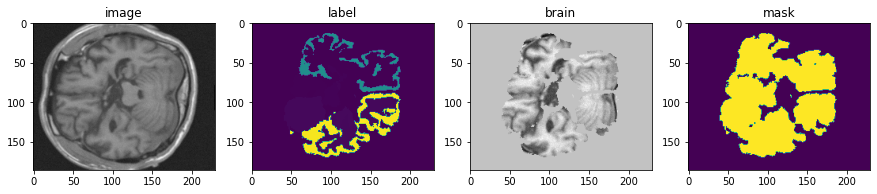

In [73]:
H=100

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
brain, mask = (check_data["brain"][0][0], check_data["mask"][0][0])
print(check_data['image'].shape, check_data['label'].shape)
print(check_data['brain'].shape, check_data['mask'].shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (15, 10))
plt.subplot(1, 4, 1)
plt.title("image")
plt.imshow(image[:, :, H], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("label")
plt.imshow(label[:, :, H])
plt.subplot(1, 4, 3)
plt.title("brain")
plt.imshow(brain[:, :, H], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("mask")
plt.imshow(mask[:, :, H])
plt.show()

In [36]:
import numpy as np
np.unique(check_data['label'][0][0]), np.unique(check_data['mask'][0][0]), np.unique(check_data['brain'][0][0])

(array([0.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 8.000e+00,
        1.000e+01, 1.100e+01, 1.200e+01, 1.300e+01, 1.400e+01, 1.500e+01,
        1.600e+01, 1.700e+01, 1.800e+01, 2.400e+01, 2.600e+01, 2.800e+01,
        3.100e+01, 4.100e+01, 4.300e+01, 4.400e+01, 4.600e+01, 4.700e+01,
        4.900e+01, 5.000e+01, 5.100e+01, 5.200e+01, 5.300e+01, 5.400e+01,
        5.800e+01, 6.000e+01, 6.300e+01, 7.700e+01, 8.500e+01, 2.510e+02,
        2.520e+02, 2.530e+02, 2.540e+02, 2.550e+02, 1.002e+03, 1.003e+03,
        1.005e+03, 1.006e+03, 1.007e+03, 1.008e+03, 1.009e+03, 1.010e+03,
        1.011e+03, 1.012e+03, 1.013e+03, 1.014e+03, 1.015e+03, 1.016e+03,
        1.017e+03, 1.018e+03, 1.019e+03, 1.020e+03, 1.021e+03, 1.022e+03,
        1.023e+03, 1.024e+03, 1.025e+03, 1.026e+03, 1.027e+03, 1.028e+03,
        1.029e+03, 1.030e+03, 1.031e+03, 1.034e+03, 1.035e+03, 2.002e+03,
        2.003e+03, 2.005e+03, 2.006e+03, 2.007e+03, 2.008e+03, 2.009e+03,
        2.010e+03, 2.011e+03, 2.012e+0

In [71]:
# 0은 배경이고 나머지 101개의 ROI가 있음.
len(np.unique(check_data['label'][0][0]))

102

In [72]:
check_data['label'][0][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 